<a href="https://colab.research.google.com/github/hijera/NN_colab_hw/blob/main/%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BA_%D0%B7%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D1%8E_%C2%AB%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B8_%D0%B4%D0%B5%D1%82%D0%B5%D0%BA%D1%86%D0%B8%D0%B8_%D0%B8_%D1%81%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D0%B8%C2%BB_(%D0%92%D0%BB%D0%B0%D1%81%D0%BE%D0%B2_%D0%90%D0%BD%D1%82%D0%BE%D0%BD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [ ]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
#import torch

from tensorflow.python.platform import build_info as tf_build_info

print(tf_build_info)
print(tf.__version__)

<module 'tensorflow.python.platform.build_info' from 'C:\\Users\\Антон\\.conda\\envs\\tf-gpu-38\\lib\\site-packages\\tensorflow\\python\\platform\\build_info.py'>
2.3.0


In [ ]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
#torch.cuda.is_available()

In [ ]:
checkpoint_name='fishdetector_3.hdf5'

In [ ]:
!nvidia-smi

Sat Feb 10 11:41:53 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.23                 Driver Version: 551.23         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
| 25%   37C    P8              3W /  100W |    1498MiB /  11264MiB |     10%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Загружаем разметку

In [ ]:
import os
import json
from glob import glob

TRAIN_PREFIX = 'data/fish/train'

def load_annotations():
    boxes = dict()
    for path in glob('data/fish/boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                annotation['classify'] = label.upper()
                annotation['filename'] = os.path.join(
                    TRAIN_PREFIX, label.upper(), basename)
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):

    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2,
                                color=color, thickness=4)
        return img

    scale_x, scale_y = 1., 1.

    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)

    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)

    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

In [ ]:
structure=os.listdir(TRAIN_PREFIX)
structure
size=len(structure)
cache_dict={}

def getClassifyEncoding(name):
    #if (name not in cache_dict):
    res=np.zeros(size)
    res[structure.index(name)]=1.
    #cache_dict[name]=res
    #else:
    #    return cache_dict[name]
    #return np.asarray(res).astype('float32')
    #return tf.convert_to_tensor(res, dtype=tf.float32)
    return res

def decode_class_pred(prediction):
    max_tuple = np.argmax(prediction) #, key=lambda x:x[1]
    print(max_tuple)
    #max_tuple_index = prediction[max_tuple,...]
    return structure[max_tuple]

def encode_classes(annot):
    return getClassifyEncoding(annot['classify'])


In [ ]:
encode_classes({'classify': "ALB"})

array([1., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
#annotation

### Визуализируем разметку

In [ ]:
boxes = load_annotations()  # загружаем разметку детекций

In [ ]:
boxes['alb'][0]

{'annotations': [{'class': 'rect',
   'height': 151.06975503141317,
   'width': 383.68430384213445,
   'x': 739.0000000000025,
   'y': 268.8946201973347}],
 'class': 'image',
 'filename': 'data/fish/train\\ALB\\img_07917.jpg',
 'classify': 'ALB'}

In [ ]:
pd.DataFrame(
    [(k, len(v)) for k, v in boxes.items()],
    columns=['class', 'count'])

,class,count
0,alb,1719
1,bet,200
2,dol,117
3,lag,67
4,shark,176
5,yft,734


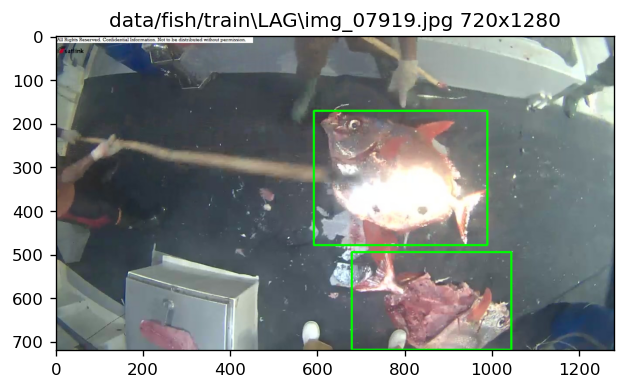

In [ ]:
from matplotlib import pyplot as plt


annotation = boxes['lag'][0]
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

### Распределение размеров разметки

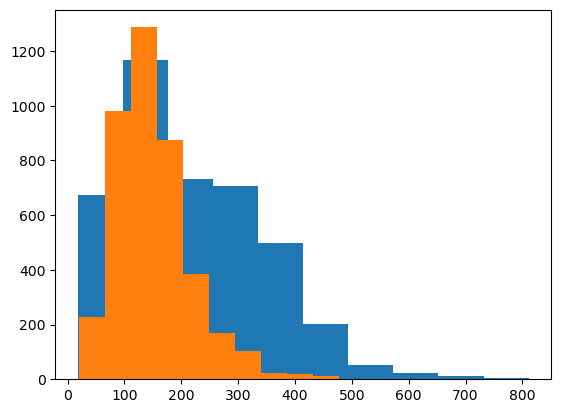

In [ ]:
annotations = sum([box['annotations']
                   for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

# Экстрактор признаков

In [ ]:
from tensorflow.keras.applications import vgg16

IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = vgg16.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False

feature_tensor = features.layers[-1].output

print(feature_tensor.shape)

(None, 23, 37, 512)


# Сетка якорей (anchor grid)

In [ ]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150.

# сетка якорей, размер определяется соотношением
# размера входного изображения и размером тензора признаков
ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [ ]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):

    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale

    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale

    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2

    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))

    intersection = dx * dy if (dx > 0 and dy > 0) else 0.

    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection

    return intersection / union


def encode_anchors(annotation, img_shape, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 5), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))

        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = [1., dx, dy, dw, dh]

    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))



def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            logit, dx, dy, dw, dh = prediction[row, col]
            conf = _sigmoid(logit)
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf})
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        return rectangles

    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)

    return [rectangles[i] for i in indices]

### Валидация энкодинга/декодинга якорей

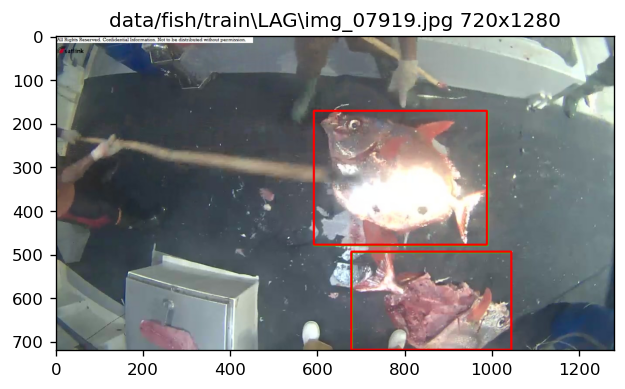

In [ ]:
annotation = boxes['lag'][0]

encoded = encode_anchors(annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.5)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

## Функция потерь

In [ ]:
def class_loss(y_true,y_pred):
    return tf.keras.metrics.categorical_crossentropy(
    y_true[..., 0],  y_pred[..., 0],from_logits=True,
    )


In [ ]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0],
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:] - y_pred[..., 1:])
    square_loss = 0.5 * K.square(y_true[..., 1:] - y_pred[..., 1:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    print(y_true)
    print(y_pred)
    batch_size = K.shape(y_true)[0]

    # TODO: добавьте функцию потерь для классификации детекции
        #classify loss
    classify_loss=class_loss(y_true,y_pred)

    y_true = K.reshape(y_true, (batch_size, -1, 5))
    y_pred = K.reshape(y_pred, (batch_size, -1, 5))

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)

    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)

    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)

    pos_class_loss = K.sum(classify_loss*y_true[...,0],axis=-1)

    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])


    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)

        # hard negative mining
   # neg_class_loss, _ = tf.nn.top_k(class_loss * (1. - y_true[..., 0]),
 #                                  k=K.cast(num_neg, 'int32'))

#    neg_class_loss = K.sum(neg_class_loss, axis=-1)


    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    total_class_loss = classify_loss
    #total_conf_loss=classsify_loss
    #loc_loss = pos_loc_loss / (num_pos + 1e-32)
    return classify_loss
    #return total_conf_loss + 0.5 * loc_loss + total_class_loss

In [ ]:
#class_loss(np.array([[0,0,0,0],[0,0,0,1]],[[0,0,0,0],[0,0,0,0.5]]))

## Загрузка данных

In [ ]:
from random import shuffle

def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
               # y.append(encode_anchors(boxes[j],img_shape))
                #print(y[0])
                y.append(encode_classes(boxes[j]))
                #print(y[0])
                X.append(img)
            yield np.array(X), np.array(y)

## Добавляем выход детектора

In [ ]:
output = tf.keras.layers.BatchNormalization()(feature_tensor)

# TODO: добавьте выходы для классификации детекции
output = tf.keras.layers.Conv2D(5,
                                kernel_size=(1, 1),
                                activation='linear',
                                kernel_regularizer='l2')(output)
output = tf.keras.layers.Flatten()(output)
output=tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(output)
output=tf.keras.layers.Dense(8, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l1(1e-4))(output)

model = tf.keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 750, 1200, 3)]    0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 750, 1200, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 750, 1200, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 375, 600, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 375, 600, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 375, 600, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 187, 300, 128)    

## Обучение

In [ ]:
adam = tf.keras.optimizers.Adam(lr=3e-4, decay=1e-6)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
batch_size = 64

gen = data_generator(boxes, batch_size=batch_size)
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_name,
    monitor='loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq=10)

model.fit(gen,
          steps_per_epoch=steps_per_epoch,
          epochs=3,
          callbacks=[checkpoint])

Epoch 1/3
 9/47 [====>.........................] - ETA: 26:02 - loss: 1.3141 - accuracy: 0.6667
Epoch 1: loss improved from inf to 1.24762, saving model to fishdetector_3.hdf5
10/47 [=====>........................] - ETA: 25:20 - loss: 1.2476 - accuracy: 0.6812

C:\Users\Антон\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/47 [===========>..................] - ETA: 19:09 - loss: 0.9637 - accuracy: 0.7590
Epoch 1: loss improved from 1.24762 to 0.94061, saving model to fishdetector_3.hdf5
29/47 [=================>............] - ETA: 12:19 - loss: 0.7821 - accuracy: 0.8071
Epoch 1: loss improved from 0.94061 to 0.76582, saving model to fishdetector_3.hdf5
39/47 [=======================>......] - ETA: 5:30 - loss: 0.6977 - accuracy: 0.8317
Epoch 1: loss improved from 0.76582 to 0.69024, saving model to fishdetector_3.hdf5
47/47 [==============================] - 1964s 42s/step - loss: 0.6200 - accuracy: 0.8545
Epoch 2/3
 1/47 [..............................] - ETA: 31:23 - loss: 0.1497 - accuracy: 1.0000
Epoch 2: loss improved from 0.69024 to 0.18324, saving model to fishdetector_3.hdf5
11/47 [======>.......................] - ETA: 24:31 - loss: 0.1943 - accuracy: 0.9787
Epoch 2: loss did not improve from 0.18324
21/47 [============>.................] - ETA: 17:46 - loss: 0.1805 - accuracy: 0.9799
Epoch 

## Результат работы детектора

In [ ]:
model.load_weights(checkpoint_name)

In [ ]:
for i in range(3):
    annotation = boxes['lag'][i]

    _, sample_img = load_img(annotation['filename'])
    pred = model.predict(np.array([sample_img,]))

    #decoded = decode_prediction(pred[0], conf_thr=0.2)
    #decoded = non_max_suppression(decoded,
    #                              max_output_size=5,
    #                              iou_threshold=0.1)

    #plt.figure(figsize=(6, 6), dpi=120)
    #img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
    #plt.imshow(img)
    #plt.title('Предсказание модели {}x{}'.format(*img.shape));
    print(pred)
    print('prediction:'+decode_class_pred(pred[0])+' vs real:'+annotation['classify'])


[[0.9090934  0.9046737  0.21975222 0.9999623  0.30358133 0.13278434
  0.0171704  0.89726794]]
3
prediction:LAG vs real:LAG
[[0.95002085 0.22017416 0.38778675 0.9908377  0.00557885 0.03294072
  0.04354233 0.7928586 ]]
3
prediction:LAG vs real:LAG
[[0.14655414 0.48828682 0.65254384 0.99906623 0.00424221 0.01325333
  0.05116332 0.8917924 ]]
3
prediction:LAG vs real:LAG


## Визуализируем предсказание на тесте

In [ ]:
#test_images = glob('data/fish/test_stg1/*.jpg')[:5]


#plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)
#
#for i, filename in enumerate(test_images):
#    _, sample_img = load_img(filename)
#    pred = model.predict(np.array([sample_img,]))#

#    decoded = decode_prediction(pred[0], conf_thr=0.0)
#    decoded = non_max_suppression(decoded,
#                                  max_output_size=2,
#                                  iou_threshold=0.1)
#
#    plt.subplot(len(test_images), 1, i + 1)
#    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
#    plt.imshow(img)
#    plt.title('Предсказание на тесте {}'.format(filename));

In [ ]:
test_files=glob('data/fish/test_stg2/*.jpg')
test_files_stg1=glob('data/fish/test_stg1/*.jpg')
test_images = test_files[:5]

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))
    print(pred)
    print('prediction:'+decode_class_pred(pred[0])+' vs real:'+annotation['classify'])

[[0.9972831  0.18222344 0.2110601  0.04892728 0.06216183 0.0069119
  0.30753005 0.8593137 ]]
0
prediction:ALB vs real:LAG
[[0.9999114  0.7170968  0.41593495 0.08500692 0.01478651 0.12165105
  0.03519195 0.2051144 ]]
0
prediction:ALB vs real:LAG
[[0.99968636 0.69104207 0.55536264 0.08704102 0.09908628 0.03953251
  0.47002375 0.9649561 ]]
0
prediction:ALB vs real:LAG
[[0.9992429  0.3203627  0.35550392 0.26301843 0.22527614 0.01259974
  0.01558283 0.7510923 ]]
0
prediction:ALB vs real:LAG
[[0.99999964 0.8958422  0.32934436 0.00173238 0.05856296 0.14965409
  0.00121236 0.44013065]]
0
prediction:ALB vs real:LAG


In [ ]:
",".join(np.array(pred.astype('str')).tolist()[0])

'0.99999964,0.8958422,0.32934436,0.0017323792,0.058562964,0.14965409,0.0012123585,0.44013065'

In [ ]:
import re
# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=1):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield load_img(path)
t_text='image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT\n'
img_data=[]
fname_data=[]
steps=256
iterator=0
items_count=0


In [ ]:
for i, filename in enumerate(test_files):
    iterator=0
    if (iterator>=steps):
        iterator=0
        pred = model.predict(np.array(img_data)) #sample_img
        j=0
        for item in pred:
            #print(np.array(item.astype('str')).tolist())
            t_text+='image_'+re.search('(\d+).jpg$', fname_data[j]).group(1)+".jpg,"+",".join(np.array(item.astype('str')).tolist())+"\n"
            j+=1
        img_data=[]
        fname_data=[]
    _, sample_img = load_img(filename)
    img_data.append(sample_img)
    fname_data.append(filename)
    iterator+=1
pred = model.predict(np.array(img_data))
j=0
for item in pred:
    #print(np.array(item.astype('str')).tolist())
    t_text+='image_'+re.search('(\d+).jpg$', fname_data[j]).group(1)+".jpg,"+",".join(np.array(item.astype('str')).tolist())+"\n"
    j+=1
#    t_text+=filename+","+",".join(np.array(pred.astype('str')).tolist()[0])+"\n"
#test_pred = model.predict(
#    predict_generator(test_files), steps=len(test_files))
with open('submit.csv', 'w') as dst:
    dst.write(t_text)
#    dst.write('image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT\n')
#    for path, score in zip(test_files, test_pred):
#        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

In [ ]:
#stage 1, чуть не забыл
t_text='image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT\n'
for i, filename in enumerate(test_files_stg1):
        _, sample_img = load_img(filename)
        pred = model.predict(np.array([sample_img])) #sample_img
        t_text+='image_'+re.search('(\d+).jpg$', filename).group(1)+".jpg,"+",".join(np.array(np.array(pred[0]).astype('str')).tolist())+"\n"
with open('submit_stg1.csv', 'w') as dst:
    dst.write(t_text)

## Агрегация результатов

In [ ]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0